In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


FILEPATH = f'../data/pnl_data/AAPL.csv'
aapl_data = pd.read_csv(FILEPATH, index_col=0, parse_dates=True)
returns = aapl_data['Adj_Close'].pct_change().dropna().rename('Rets')
returns

Date
2010-01-05 00:00:00+00:00    0.001729
2010-01-06 00:00:00+00:00   -0.015906
2010-01-07 00:00:00+00:00   -0.001849
2010-01-08 00:00:00+00:00    0.006648
2010-01-11 00:00:00+00:00   -0.008821
                               ...   
2020-12-23 00:00:00+00:00   -0.006976
2020-12-24 00:00:00+00:00    0.007712
2020-12-28 00:00:00+00:00    0.035766
2020-12-29 00:00:00+00:00   -0.013315
2020-12-30 00:00:00+00:00   -0.008527
Name: Rets, Length: 2767, dtype: float64

## Rachev Ratio
The Rachev Ratio is defined as the ratio of the Expected Tail Return (ETR) to the Expected Tail Loss (ETL):
$$ Rachev\;Ratio = \frac{ETR}{ETL}$$
#### Interpretation:
* Rachev Ra


### Empirical Rachev Ratio

In [98]:
# Define Input params
q = 0.05
symmetric = True
########################
if symmetric:
    upper_q = 1-q
    lower_q = q
else:
    # if not symmetric, define here
    upper_q = 0.95
    lower_q = 0.05

In [99]:
### Empirical Rachev Ratio
upper_threshold = returns.quantile(upper_q)
lower_threshold = returns.quantile(lower_q)
etr = returns[returns >= upper_threshold].mean()
etl = returns[returns <= lower_threshold].mean()
if etl:
    empirical_rachev_ratio = etr/-etl
else:
    empirical_rachev_ratio = np.nan
print(f"Expected Tail Return (Above {upper_q*100}%): {etr:.6f}")
print(f"Expected Tail Loss (Below {lower_q*100}%): {etl:.6f}")
print(f'Higher means better reward-risk ratio')
print(f'Empirical Rachev Ratio: {empirical_rachev_ratio:.6f}')



Expected Tail Return (Above 95.0%): 0.042230
Expected Tail Loss (Below 5.0%): -0.040440
Higher means better reward-risk ratio
Empirical Rachev Ratio: 1.044275


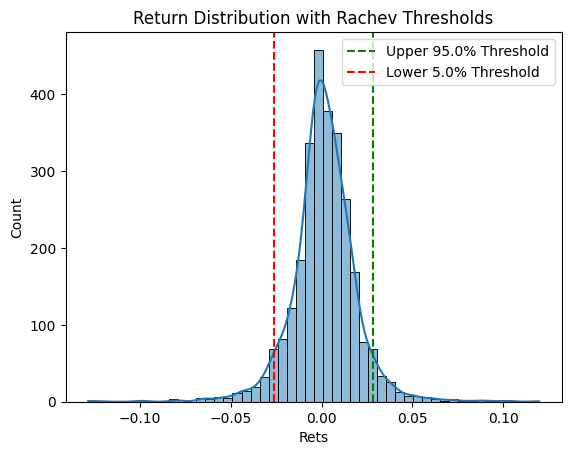

In [100]:
def plot_rachev_thresholds(returns, upper_alpha, lower_beta):
    sns.histplot(returns, bins=50, kde=True)
    upper_thresh = returns.quantile(upper_alpha)
    lower_thresh = returns.quantile(lower_beta)
    plt.axvline(upper_thresh, color='green', linestyle='--', label=f'Upper {upper_alpha*100}% Threshold')
    plt.axvline(lower_thresh, color='red', linestyle='--', label=f'Lower {lower_beta*100}% Threshold')
    plt.legend()
    plt.title('Return Distribution with Rachev Thresholds')
    plt.show()

# Example usage:
plot_rachev_thresholds(returns, upper_q, lower_q)

### Parametric Rachev - Skew Normal Dist

In [101]:
'''
Calc the moments based from returns and fit a skew-normal dist using scipy
'''

from scipy import stats, integrate
from scipy.optimize import minimize

mean_rets = returns.mean()
std_rets =  returns.std()
skew_rets = returns.skew()
kurt_rets = returns.kurtosis()

def fit_skew_normal(mean, std, skew):
    """
    Fit a skew-normal distribution to match the given mean, std, and skewness.
    
    Parameters:
    - mean (float): Mean of the distribution.
    - std (float): Standard deviation of the distribution.
    - skew (float): Skewness of the distribution.
    
    Returns:
    - params (tuple): Parameters of the skew-normal distribution (alpha, loc, scale).
    """
    # Initial guess for parameters
    initial_alpha = skew
    initial_loc = mean
    initial_scale = std

    # Define the objective function (sum of squared differences of moments)
    def objective(params):
        alpha, loc, scale = params
        fitted_mean = stats.skewnorm.mean(a=alpha, loc=loc, scale=scale)
        fitted_var = stats.skewnorm.var(a=alpha, loc=loc, scale=scale)
        fitted_skew = stats.skewnorm.stats(a=alpha, loc=loc, scale=scale, moments='s')
        
        # Calculate squared errors
        error_mean = (fitted_mean - mean) ** 2
        error_var = (np.sqrt(fitted_var) - std) ** 2
        error_skew = (fitted_skew - skew) ** 2
        
        return error_mean + error_var + error_skew

    # Optimize the parameters
    result = minimize(objective, x0=[initial_alpha, initial_loc, initial_scale],
                      bounds=[(None, None), (None, None), (1e-6, None)],
                      method='L-BFGS-B')
    
    if result.success:
        fitted_alpha, fitted_loc, fitted_scale = result.x
        return fitted_alpha, fitted_loc, fitted_scale
    else:
        raise RuntimeError("Optimization failed. Try different initial parameters or a different distribution.")

# Fit the skew-normal distribution
alpha, loc, scale = fit_skew_normal(mean_rets, std_rets, skew_rets)
print(f"Fitted Skew-Normal Parameters:\nAlpha: {alpha:.4f}, Loc: {loc:.6f}, Scale: {scale:.6f}")

Fitted Skew-Normal Parameters:
Alpha: -0.8834, Loc: 0.012345, Scale: 0.021005


In [102]:
# define thresholds:
upper_threshold = stats.skewnorm.ppf(upper_q, a=alpha, loc=loc, scale=scale)
lower_threshold = stats.skewnorm.ppf(lower_q, a=alpha, loc=loc, scale=scale)

In [103]:
def compute_tail_expectations_skew_normal(a, loc, scale, upper_threshold, lower_threshold):
    """
    Calculate both the Expected Tail Return (ETR) and Expected Tail Loss (ETL) 
    for a skew-normal distribution.
    
    Parameters:
    - a (float): Shape parameter (alpha) of the skew-normal distribution.
    - loc (float): Location parameter of the skew-normal distribution.
    - scale (float): Scale parameter of the skew-normal distribution.
    - upper_threshold (float): Threshold for the upper tail (e.g., 95th percentile).
    - lower_threshold (float): Threshold for the lower tail (e.g., 5th percentile).
    
    Returns:
    - etr (float): Expected Tail Return.
    - etl (float): Expected Tail Loss.
    """
    # Define the PDF of the skew-normal distribution
    pdf = lambda x: stats.skewnorm.pdf(x, a, loc=loc, scale=scale)
    
    # Expected Tail Return (ETR)
    # Integral of r * f(r) from upper_threshold to infinity
    integrand_etr = lambda x: x * pdf(x)
    integral_etr, _ = integrate.quad(integrand_etr, upper_threshold, np.inf)
    # Survival function at upper_threshold
    survival = stats.skewnorm.sf(upper_threshold, a, loc=loc, scale=scale)
    etr = integral_etr / survival if survival > 0 else np.nan
    
    # Expected Tail Loss (ETL)
    # Integral of (-r) * f(r) from -infinity to lower_threshold
    integrand_etl = lambda x: x * pdf(x)
    integral_etl, _ = integrate.quad(integrand_etl, -np.inf, lower_threshold)
    # CDF at lower_threshold
    cdf = stats.skewnorm.cdf(lower_threshold, a, loc=loc, scale=scale)
    etl = integral_etl / cdf if cdf > 0 else np.nan  # Negative sign for loss
    
    return etr, etl


# Calculate Expected Tail Return and Loss
etr, etl = compute_tail_expectations_skew_normal(alpha, loc, scale, upper_threshold, lower_threshold)

print(f"Expected Tail Return (Above {upper_q*100}%): {etr:.6f}")
print(f"Expected Tail Loss (Below {lower_q*100}%): {etl:.6f}")

if etl:
    empirical_rachev_ratio = etr/-etl
else:
    empirical_rachev_ratio = np.nan
print(f'Higher means better reward-risk ratio')
print(f'Parametric (Skew-Normal) Rachev Ratio: {empirical_rachev_ratio:.6f}')


Expected Tail Return (Above 95.0%): 0.037072
Expected Tail Loss (Below 5.0%): -0.036653
Higher means better reward-risk ratio
Parametric (Skew-Normal) Rachev Ratio: 1.011440


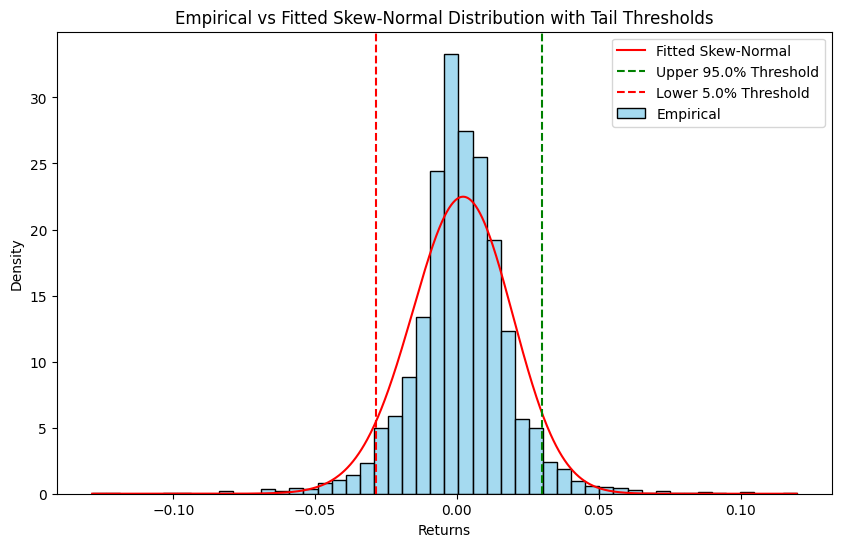

In [104]:
def plot_fitted_distribution_with_tails(returns, a, loc, scale, upper_alpha, lower_beta):
    """
    Plot the empirical returns distribution with the fitted skew-normal distribution and tail thresholds.
    
    Parameters:
    - returns (pd.Series): Series of asset returns.
    - a (float): Shape parameter (alpha) of the skew-normal distribution.
    - loc (float): Location parameter of the skew-normal distribution.
    - scale (float): Scale parameter of the skew-normal distribution.
    - upper_alpha (float): Confidence level for the upper tail.
    - lower_beta (float): Confidence level for the lower tail.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot empirical histogram
    sns.histplot(returns, bins=50, stat='density', label='Empirical', color='skyblue', kde=False)
    
    # Plot fitted skew-normal PDF
    x = np.linspace(returns.min(), returns.max(), 1000)
    pdf_fitted = stats.skewnorm.pdf(x, a, loc=loc, scale=scale)
    plt.plot(x, pdf_fitted, 'r-', label='Fitted Skew-Normal')
    
    # Plot upper and lower thresholds
    upper_threshold = stats.skewnorm.ppf(upper_alpha, a, loc=loc, scale=scale)
    lower_threshold = stats.skewnorm.ppf(lower_beta, a, loc=loc, scale=scale)
    plt.axvline(upper_threshold, color='green', linestyle='--', label=f'Upper {upper_alpha*100}% Threshold')
    plt.axvline(lower_threshold, color='red', linestyle='--', label=f'Lower {lower_beta*100}% Threshold')
    
    plt.legend()
    plt.title('Empirical vs Fitted Skew-Normal Distribution with Tail Thresholds')
    plt.xlabel('Returns')
    plt.ylabel('Density')
    plt.show()

# Example usage:
plot_fitted_distribution_with_tails(returns, alpha, loc, scale, upper_alpha=0.95, lower_beta=0.05)


### Generalized Lambda Distribution (GLD)

#### What is GLD?
The Generalized Lambda Distribution (GLD) is a flexible family of probability distributions defined by its quantile function. Introduced by Freimer, Genest, and Nešlehová in 1988, the GLD can approximate a wide range of distribution shapes, including those with varying skewness and kurtosis.

#### Quantile function of GLD
The GLD is typically defined via its quantile function (inverse CDF) as follows:
$$Q(u;\lambda_1,\lambda_2,\lambda_3,\lambda_4)=\lambda_1+\frac{(u^{\lambda_3}-(1-u)^{\lambda_1})}{\lambda_2},\;\;0<u<1$$
Where:
* $\lambda_1$ (location parameter) shifts the distribution along the x-axis.
* $\lambda_2$ (scale parameter) stretches or compresses the distribution.
* $\lambda_3$ and $\lambda_4$ (shape parameters) control the skewness and kurtosis.

#### Why GLD?
* __Flexibility__: GLD can mimic various distribution shapes, including normal, uniform, exponential, and more.
* __Parameter Interpretation__: The shape parameters allow for direct control over skewness and kurtosis.
* __Applicability__: Particularly useful in financial modeling where asset returns often exhibit skewness and heavy tails.


In [105]:
### Define GLD Quantile func
def gld_quantile(u, lambda1, lambda2, lambda3, lambda4):
    """
    Quantile function for the Generalized Lambda Distribution (GLD).

    Parameters:
    - u (float or array-like): Probability levels (0 < u < 1).
    - lambda1 (float): Location parameter.
    - lambda2 (float): Scale parameter.
    - lambda3 (float): Shape parameter 1.
    - lambda4 (float): Shape parameter 2.

    Returns:
    - Quantile values corresponding to the probabilities u.
    """
    # Convert u to a NumPy array for element-wise operations
    u = np.asarray(u)
    
    # Ensure that u is within (0, 1)
    if np.any(u <= 0) or np.any(u >= 1):
        raise ValueError("All probability values 'u' must be in the open interval (0, 1).")
    
    return lambda1 + (np.power(u, lambda3) - np.power(1 - u, lambda4)) / lambda2


### Define func for optimisation:
def gld_mse(params, empirical_quantiles, probs):
    """
    Mean Squared Error between empirical quantiles and GLD quantiles.

    Parameters:
    - params (tuple): GLD parameters (lambda1, lambda2, lambda3, lambda4).
    - empirical_quantiles (array-like): Empirical quantiles.
    - probs (array-like): Corresponding probabilities for the quantiles.

    Returns:
    - mse (float): Mean Squared Error.
    """
    lambda1, lambda2, lambda3, lambda4 = params
    
    # Prevent division by zero or negative scale parameters
    if lambda2 <= 0:
        return np.inf
    
    try:
        gld_q = gld_quantile(probs, lambda1, lambda2, lambda3, lambda4)
    except ValueError as e:
        # If u is out of bounds, return a large MSE
        return np.inf
    
    mse = np.mean((empirical_quantiles - gld_q) ** 2)
    return mse


In [106]:
### Fitting GLD to data
def fit_gld(data, probs=None):
    """
    Fit the Generalized Lambda Distribution (GLD) to the data using quantile matching.

    Parameters:
    - data (array-like): Sample data to fit.
    - probs (array-like, optional): Probabilities for quantiles. Defaults to [0.1, 0.3, 0.7, 0.9].

    Returns:
    - fitted_params (tuple): Estimated GLD parameters (lambda1, lambda2, lambda3, lambda4).
    """
    if probs is None:
        probs = [0.1, 0.3, 0.7, 0.9]  # Default quantiles

    # Calculate empirical quantiles
    empirical_q = np.quantile(data, probs)

    # Initial parameter guesses
    lambda1_init = empirical_q[1]
    lambda2_init = empirical_q[3] - empirical_q[0] if (empirical_q[3] - empirical_q[0]) > 0 else 1.0
    lambda3_init = 1.0
    lambda4_init = 1.0

    initial_params = [lambda1_init, lambda2_init, lambda3_init, lambda4_init]

    # Define bounds to ensure reasonable parameter values
    # lambda2 (scale) > 0, lambda3 and lambda4 > 0
    bounds = [(None, None), (1e-6, None), (1e-6, None), (1e-6, None)]

    # Perform optimization
    result = minimize(
        gld_mse,
        x0=initial_params,
        args=(empirical_q, probs),
        method='L-BFGS-B',
        bounds=bounds
    )

    if result.success:
        fitted_params = result.x
        return tuple(fitted_params)
    else:
        raise RuntimeError("GLD fitting failed. Optimization did not converge.")



In [107]:
### Usage of above
# Fit GLD
fitted_lambda1, fitted_lambda2, fitted_lambda3, fitted_lambda4 = fit_gld(returns)

print(f"Fitted GLD Parameters:\nLambda1: {fitted_lambda1:.6f}, Lambda2: {fitted_lambda2:.6f}, "
      f"Lambda3: {fitted_lambda3:.6f}, Lambda4: {fitted_lambda4:.6f}")

Fitted GLD Parameters:
Lambda1: 0.002603, Lambda2: 3.399569, Lambda3: 0.032192, Lambda4: 0.026962


In [108]:
### Approximate GLD PDF
def approximate_gld_pdf(x, lambda1, lambda2, lambda3, lambda4, num_sim=100000):
    """
    Numerically approximate the PDF of the GLD using simulation and Kernel Density Estimation (KDE).

    Parameters:
    - x (float or array-like): Points at which to evaluate the PDF.
    - lambda1, lambda2, lambda3, lambda4: GLD parameters.
    - num_sim (int): Number of samples to simulate.

    Returns:
    - pdf (float or array-like): Approximated PDF values at x.
    """
    # Simulate samples from the GLD
    u = np.random.uniform(0, 1, num_sim)
    samples = gld_quantile(u, lambda1, lambda2, lambda3, lambda4)

    # Use Gaussian KDE to estimate the PDF
    kde = stats.gaussian_kde(samples)
    return kde.evaluate(x)


In [109]:
### Compute etr etl
def compute_tail_expectations_gld(lambda1, lambda2, lambda3, lambda4, upper_alpha=0.95, lower_beta=0.05, num_sim=100000):
    """
    Calculate both the Expected Tail Return (ETR) and Expected Tail Loss (ETL) 
    for a Generalized Lambda Distribution (GLD) using simulation.

    Parameters:
    - lambda1, lambda2, lambda3, lambda4: GLD parameters.
    - upper_alpha (float): Confidence level for the upper tail (e.g., 0.95).
    - lower_beta (float): Confidence level for the lower tail (e.g., 0.05).
    - num_sim (int): Number of samples to simulate.

    Returns:
    - etr (float): Expected Tail Return.
    - etl (float): Expected Tail Loss.
    """
    # Calculate thresholds
    upper_threshold = gld_quantile(upper_alpha, lambda1, lambda2, lambda3, lambda4)
    lower_threshold = gld_quantile(lower_beta, lambda1, lambda2, lambda3, lambda4)

    # Simulate samples from the GLD
    u = np.random.uniform(0, 1, num_sim)
    samples = gld_quantile(u, lambda1, lambda2, lambda3, lambda4)

    # ETR: Mean of samples >= upper_threshold
    tail_returns = samples[samples >= upper_threshold]
    etr = np.mean(tail_returns) if len(tail_returns) > 0 else np.nan

    # ETL: Mean of -samples <= lower_threshold
    tail_losses = samples[samples <= lower_threshold]
    etl = -np.mean(tail_losses) if len(tail_losses) > 0 else np.nan

    return etr, etl

### Calc Rachev Ratio
def calculate_gld_rachev_ratio(returns, upper_alpha=0.95, lower_beta=0.05, quantile_probs=None):
    """
    Calculate the Rachev Ratio using the Generalized Lambda Distribution (GLD).

    Parameters:
    - returns (pd.Series or array-like): Series of asset returns.
    - upper_alpha (float): Confidence level for the upper tail (e.g., 0.95).
    - lower_beta (float): Confidence level for the lower tail (e.g., 0.05).
    - quantile_probs (array-like, optional): Probabilities for quantile matching. Defaults to [0.1, 0.3, 0.7, 0.9].

    Returns:
    - rachev_ratio (float): The Rachev Ratio.
    - etr (float): Expected Tail Return.
    - etl (float): Expected Tail Loss.
    - fitted_params (tuple): Fitted GLD parameters (lambda1, lambda2, lambda3, lambda4).
    """
    # Step 1: Fit GLD to the data
    fitted_params = fit_gld(returns, probs=quantile_probs)
    lambda1, lambda2, lambda3, lambda4 = fitted_params

    # Step 2: Compute ETR and ETL
    etr, etl = compute_tail_expectations_gld(lambda1, lambda2, lambda3, lambda4, upper_alpha, lower_beta)

    # Step 3: Calculate Rachev Ratio
    if etl != 0 and not np.isnan(etl):
        rachev_ratio = etr / etl
    else:
        rachev_ratio = np.nan  # Handle division by zero or undefined

    return rachev_ratio, etr, etl, fitted_params


In [124]:
### Running it altogether
quantiles = np.arange(0.05,1,0.05)
rachev_ratio, etr, etl, fitted_params = calculate_gld_rachev_ratio(returns, upper_alpha=upper_q, lower_beta=lower_q, quantile_probs=quantiles)
# Display Results
print(f"Fitted GLD Parameters:\nLambda1: {fitted_params[0]:.6f}, Lambda2: {fitted_params[1]:.6f}, "
        f"Lambda3: {fitted_params[2]:.6f}, Lambda4: {fitted_params[3]:.6f}")
print(f"Expected Tail Return (Above 95%): {etr:.6f}")
print(f"Expected Tail Loss (Below 5%): {etl:.6f}")
print(f"Rachev Ratio: {rachev_ratio:.4f}")

Fitted GLD Parameters:
Lambda1: 0.001722, Lambda2: 3.499008, Lambda3: 0.032246, Lambda4: 0.030476
Expected Tail Return (Above 95%): 0.034046
Expected Tail Loss (Below 5%): 0.032548
Rachev Ratio: 1.0460


In [125]:
### Plot
# Plot GLD with Tail Thresholds
def plot_gld_with_tails(returns, lambda1, lambda2, lambda3, lambda4, upper_alpha=0.95, lower_beta=0.05, num_sim=100000):
    plt.figure(figsize=(10, 6))
    sns.histplot(returns, bins=50, stat='density', label='Empirical', color='skyblue', kde=False)
    x = np.linspace(returns.min(), returns.max(), 1000)
    pdf_fitted = approximate_gld_pdf(x, lambda1, lambda2, lambda3, lambda4, num_sim=num_sim)
    plt.plot(x, pdf_fitted, 'r-', label='Fitted GLD (Approximate PDF)')
    upper_threshold = gld_quantile(upper_alpha, lambda1, lambda2, lambda3, lambda4)
    lower_threshold = gld_quantile(lower_beta, lambda1, lambda2, lambda3, lambda4)
    plt.axvline(upper_threshold, color='green', linestyle='--', label=f'Upper {upper_alpha*100}% Threshold')
    plt.axvline(lower_threshold, color='red', linestyle='--', label=f'Lower {lower_beta*100}% Threshold')
    plt.legend()
    plt.title('Empirical vs Fitted GLD with Tail Thresholds')
    plt.xlabel('Returns')
    plt.ylabel('Density')
    plt.show()

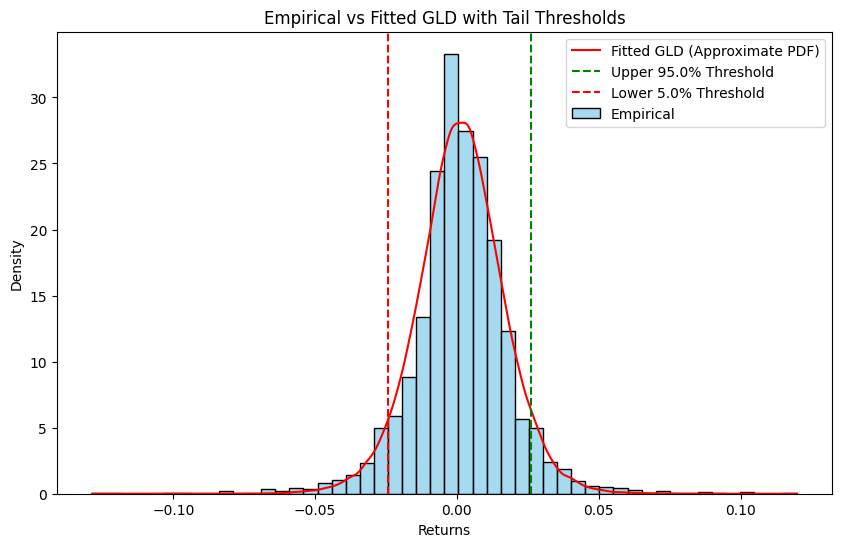

In [126]:
 # Plot the Distribution with Tail Thresholds
plot_gld_with_tails(returns, fitted_params[0], fitted_params[1], fitted_params[2], fitted_params[3],
                    upper_alpha=0.95, lower_beta=0.05)

#### Check goodness of fit of GLD by performing Kolmogoroc-Smirnov (KS) test

In [127]:
def perform_ks_test(returns, lambda1, lambda2, lambda3, lambda4, num_sim=100000):
    """
    Perform the Kolmogorov-Smirnov test between empirical data and fitted GLD.

    Parameters:
    - returns (pd.Series or array-like): Sample data.
    - lambda1, lambda2, lambda3, lambda4: GLD parameters.
    - num_sim (int): Number of samples to simulate for CDF approximation.

    Returns:
    - ks_stat (float): KS statistic.
    - p_value (float): p-value of the test.
    """
    # Simulate samples from the fitted GLD
    u = np.random.uniform(0, 1, num_sim)
    simulated_samples = gld_quantile(u, lambda1, lambda2, lambda3, lambda4)
    simulated_sorted = np.sort(simulated_samples)
    
    # Empirical sorted data
    empirical_sorted = np.sort(returns)
    cdf_empirical = np.arange(1, len(empirical_sorted)+1) / len(empirical_sorted)
    
    # Compute GLD CDF at empirical sorted points via interpolation
    cdf_simulated = np.searchsorted(simulated_sorted, empirical_sorted, side='right') / num_sim
    
    # KS statistic
    ks_stat = np.max(np.abs(cdf_empirical - cdf_simulated))
    
    # Approximate p-value using scipy's ks test (note: this is approximate)
    # Here, we use a simplistic approach; for rigorous testing, specialized methods are needed
    p_value = 1 - stats.kstest(simulated_samples, 'norm', args=(np.mean(simulated_samples), np.std(simulated_samples))).pvalue

    return ks_stat, p_value

# Perform KS Test
ks_stat, p_value = perform_ks_test(returns, fitted_params[0], fitted_params[1], fitted_params[2], fitted_params[3])
print(f"KS Statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")


KS Statistic: 0.0305, p-value: 1.0000


Interpretation:

* High p-value (> 0.05): The GLD is a plausible fit for the data.
* Low p-value (<= 0.05): The GLD may not adequately capture the data distribution.